## Imports

In [1]:
import yaml
import confuse
import hickle as hkl
import pickle
import pandas as pd
import numpy as np
import os
from natsort import natsorted
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import h5py
from catboost import CatBoostClassifier


In [2]:
## Load configuration 
config = confuse.Configuration('plantation_classifier')
config.set_file('/Users/jessica.ertel/plantation_classifier/config.yaml')
aws_key = config['aws']['aws_access_key_id']
aws_secret_key = config['aws']['aws_secret_access_key']
aws_region = config['aws_region']

In [4]:
# update paths
# aws s3 sync s3://restoration-monitoring/plantation-mapping/data/train/train-features /Users/jessica.ertel/plantation_classifier/data/train-features &&
# aws s3 sync s3://restoration-monitoring/plantation-mapping/data/train/train-s1 /Users/jessica.ertel/plantation_classifier/data/train-s1 &&
# aws s3 sync s3://restoration-monitoring/plantation-mapping/data/train/train-s2 /Users/jessica.ertel/plantation_classifier/data/train-s2 &&
# aws s3 sync s3://restoration-monitoring/plantation-mapping/data/train/train-slope /Users/jessica.ertel/plantation_classifier/data/train-slope &&
# aws s3 sync s3://restoration-monitoring/plantation-mapping/data/train/train-labels /Users/jessica.ertel/plantation_classifier/data/train-labels &&
# aws s3 sync s3://restoration-monitoring/plantation-mapping/data/train/train-features-ckpt-2023-02-09 /Users/jessica.ertel/plantation_classifier/data/train-features-ckpt-2023-02-09/
# aws s3 sync s3://restoration-monitoring/plantation-mapping/data/train/train-plantation-ard /Users/jessica.ertel/plantation_classifier/data/train-ard
    

In [6]:
folder = '/Users/jessica.ertel/github/plantation_classifier/data/'
print(len(os.listdir(f'{folder}train-features/')) + len(os.listdir(f'{folder}train-features-ckpt-2023-02-09/')))
print(len(os.listdir(f'{folder}train-s1/')))
print(len(os.listdir(f'{folder}train-s2/')))
print(len(os.listdir(f'{folder}train-slope/')))
print(len(os.listdir(f'{folder}train-labels/')))
print(len(os.listdir(f'{folder}train-texture/')))
print(len(os.listdir(f'{folder}train-ard')))

3361
2171
1920
2167
2176
1725
920


In [39]:
# which files are in s2 that are not in ARD
# 'v08','v14', 'v15', 'v18', 'v19', 'v20'

s2 = [f for f in os.listdir(f'{folder}train-s2/') if not f.startswith('.')]
ard = [f for f in os.listdir(f'{folder}train-ard/') if not f.startswith('.')]
ard_int = [int(i[:-4]) for i in ard]
diff = [int(i[:-4]) for i in s2 if i not in ard]
missing_v08 = [i for i in diff if i >= 8000 and i <= 9000]
missing_v14_15 = [i for i in diff if i >= 14000 and i <= 16000]

len(missing_v14_15)

299

In [45]:
# how much ard is there for v20?

ard_v8 = [i for i in ard_int if i >= 8000 if i <= 9000]
ard_v15 = [i for i in ard_int if i >= 14000 if i <= 16000]
ard_v20 = [i for i in ard_int if i >= 18000 if i <= 21000]
len(ard_v8) + len(ard_v15) + len(ard_v20)

885

In [18]:
# training
plot = 20158
ard = np.load(f'{folder}train-ard/{plot}.npy')
ard.shape

(12, 28, 28, 17)

In [20]:
s1 = hkl.load(f'{folder}train-s1/{plot}.hkl')
s2 = hkl.load(f'{folder}train-s2/{plot}.hkl')
dem = np.load(f'{folder}train-slope/{plot}.npy')

In [12]:
# deployment
x = 1668
y = 1077
ard = hkl.load(f'../tmp/ghana/{str(x)}/{str(y)}/ard/{str(x)}X{str(y)}Y_ard.hkl')
ard.shape

dem = ard[..., 0]
s1 = ard[..., 1:3]
s2 = ard[..., 3:13]

(618, 614, 13)

In [5]:
s2 = os.listdir('/Users/jessica.ertel/plantation_classifier/data/train-s2/')
txt = os.listdir('/Users/jessica.ertel/plantation_classifier/data/train-texture/')
diff = [i for i in txt if i not in s2]

In [15]:
def multiplot(matrices, nrows = 13, ncols = 6):
    '''Docstring
    
         Parameters:
          matrices (list):
          nrows (int):
          
         Returns:
          None
    '''
    fig, axs = plt.subplots(ncols = ncols, nrows = nrows)
    fig.set_size_inches(18, 3.25*nrows)
    to_iter = [[x for x in range(i, i + ncols + 1)] for i in range(0, nrows*ncols, ncols)]
    counter = 0
    for r in range(1, nrows + 1):
        min_i = min(to_iter[r-1])
        max_i = max(to_iter[r-1])
        for i in range(ncols):
            sns.heatmap(data = matrices[..., counter], ax = axs[r - 1, i], cbar = False,
                       cmap = sns.color_palette("viridis", as_cmap=True))
            axs[r - 1, i].set_xlabel("")
            axs[r - 1, i].set_ylabel("")
            axs[r - 1, i].set_yticks([])
            axs[r - 1, i].set_xticks([])
            counter += 1
    plt.show

multiplot(f)def make_sample(shape, slope, s1, s2, feats):
    
    ''' 
    Defines dimensions and then combines 4 features from a plot
    into a sample with shape (14, 14, feature_count)
    '''
    
    # define dimensions for array
    n_feats = 1 + s1.shape[-1] + s2.shape[-1] + feats.shape[-1]

    sample = np.empty((shape[1], shape[-1], n_feats))
    
    # populate empty array with each feature
    sample[..., 0] = slope
    sample[..., 1:3] = s1
    sample[..., 3:13] = s2
    sample[..., 13:] = feats
    
    return sample

## OLD
def create_xy(sample_shape, v_train_data, drop_prob, verbose=False):
    '''
    Creates an empty array for x and y based on the training data set
    then creates samples and labels by loading data by plot ID. 
    Combines all samples into a single array as input to the model.
    Also returns a baseline accuracy score (indicating class imbalance)
    '''
    # use CEO csv to gather plot id numbers
    if len(v_train_data) == 1:
        df = pd.read_csv(f'../data/ceo-plantations-train-{v_train_data[0]}.csv')
        plot_ids = df.plotid.drop_duplicates().tolist()
    
    elif len(v_train_data) > 1:
        df1 = pd.read_csv(f'../data/ceo-plantations-train-{v_train_data[0]}.csv')
        df2 = pd.read_csv(f'../data/ceo-plantations-train-{v_train_data[1]}.csv')
        plot_ids = df1.plotid.drop_duplicates().tolist() + df2.plotid.drop_duplicates().tolist()
    
    # check and remove any plot ids where there are no cloud free images (no feats or s2)
    for i in plot_ids:
        if not os.path.exists(f'../data/train-s2/{i}.hkl') and os.path.exists(f'../data/train-features/{i}.hkl'):
            print(f'Plot id {i} has no cloud free imagery and will be removed.')
            plot_ids.remove(i)

    # create empty x and y array based on number of plots
    n_samples = len(plot_ids)
    y_all = np.empty(shape=(n_samples, 14, 14))
    if drop_prob:
        x_all = np.empty(shape=(n_samples, 14, 14, 77))
    else:
        x_all = np.empty(shape=(n_samples, 14, 14, 78))
    
    for num, plot in enumerate(plot_ids):
        
        # at index i, load and create the sample, then append to empty array
        X = make_sample(sample_shape, load_slope(plot), load_s1(plot), load_s2(plot), load_feats(plot, drop_prob))
        y = load_label(plot)
        x_all[num] = X
        y_all[num] = y

        if verbose:
            print(f'Sample: {num}')
            print(f'Features: {X.shape}, Labels: {y.shape}')
        
    # check class balance and baseline accuracy
    labels, counts = np.unique(y_all, return_counts=True)
    print(f'Baseline: {round(counts[0] / (counts[0] + counts[1]), 3)}')

    return x_all, y_all
        

In [91]:
def multiplot(matrices, nrows = 13, ncols = 6):
    '''Docstring
    
         Parameters:
          matrices (list):
          nrows (int):
          
         Returns:
          None
    '''
    fig, axs = plt.subplots(ncols = ncols, nrows = nrows)
    fig.set_size_inches(18, 3.25*nrows)
    to_iter = [[x for x in range(i, i + ncols + 1)] for i in range(0, nrows*ncols, ncols)]
    counter = 0
    for r in range(1, nrows + 1):
        min_i = min(to_iter[r-1])
        max_i = max(to_iter[r-1])
        for i in range(ncols):
            sns.heatmap(data = matrices[..., counter], ax = axs[r - 1, i], cbar = False,
                       cmap = sns.color_palette("viridis", as_cmap=True))
            axs[r - 1, i].set_xlabel("")
            axs[r - 1, i].set_ylabel("")
            axs[r - 1, i].set_yticks([])
            axs[r - 1, i].set_xticks([])
            counter += 1
    plt.show

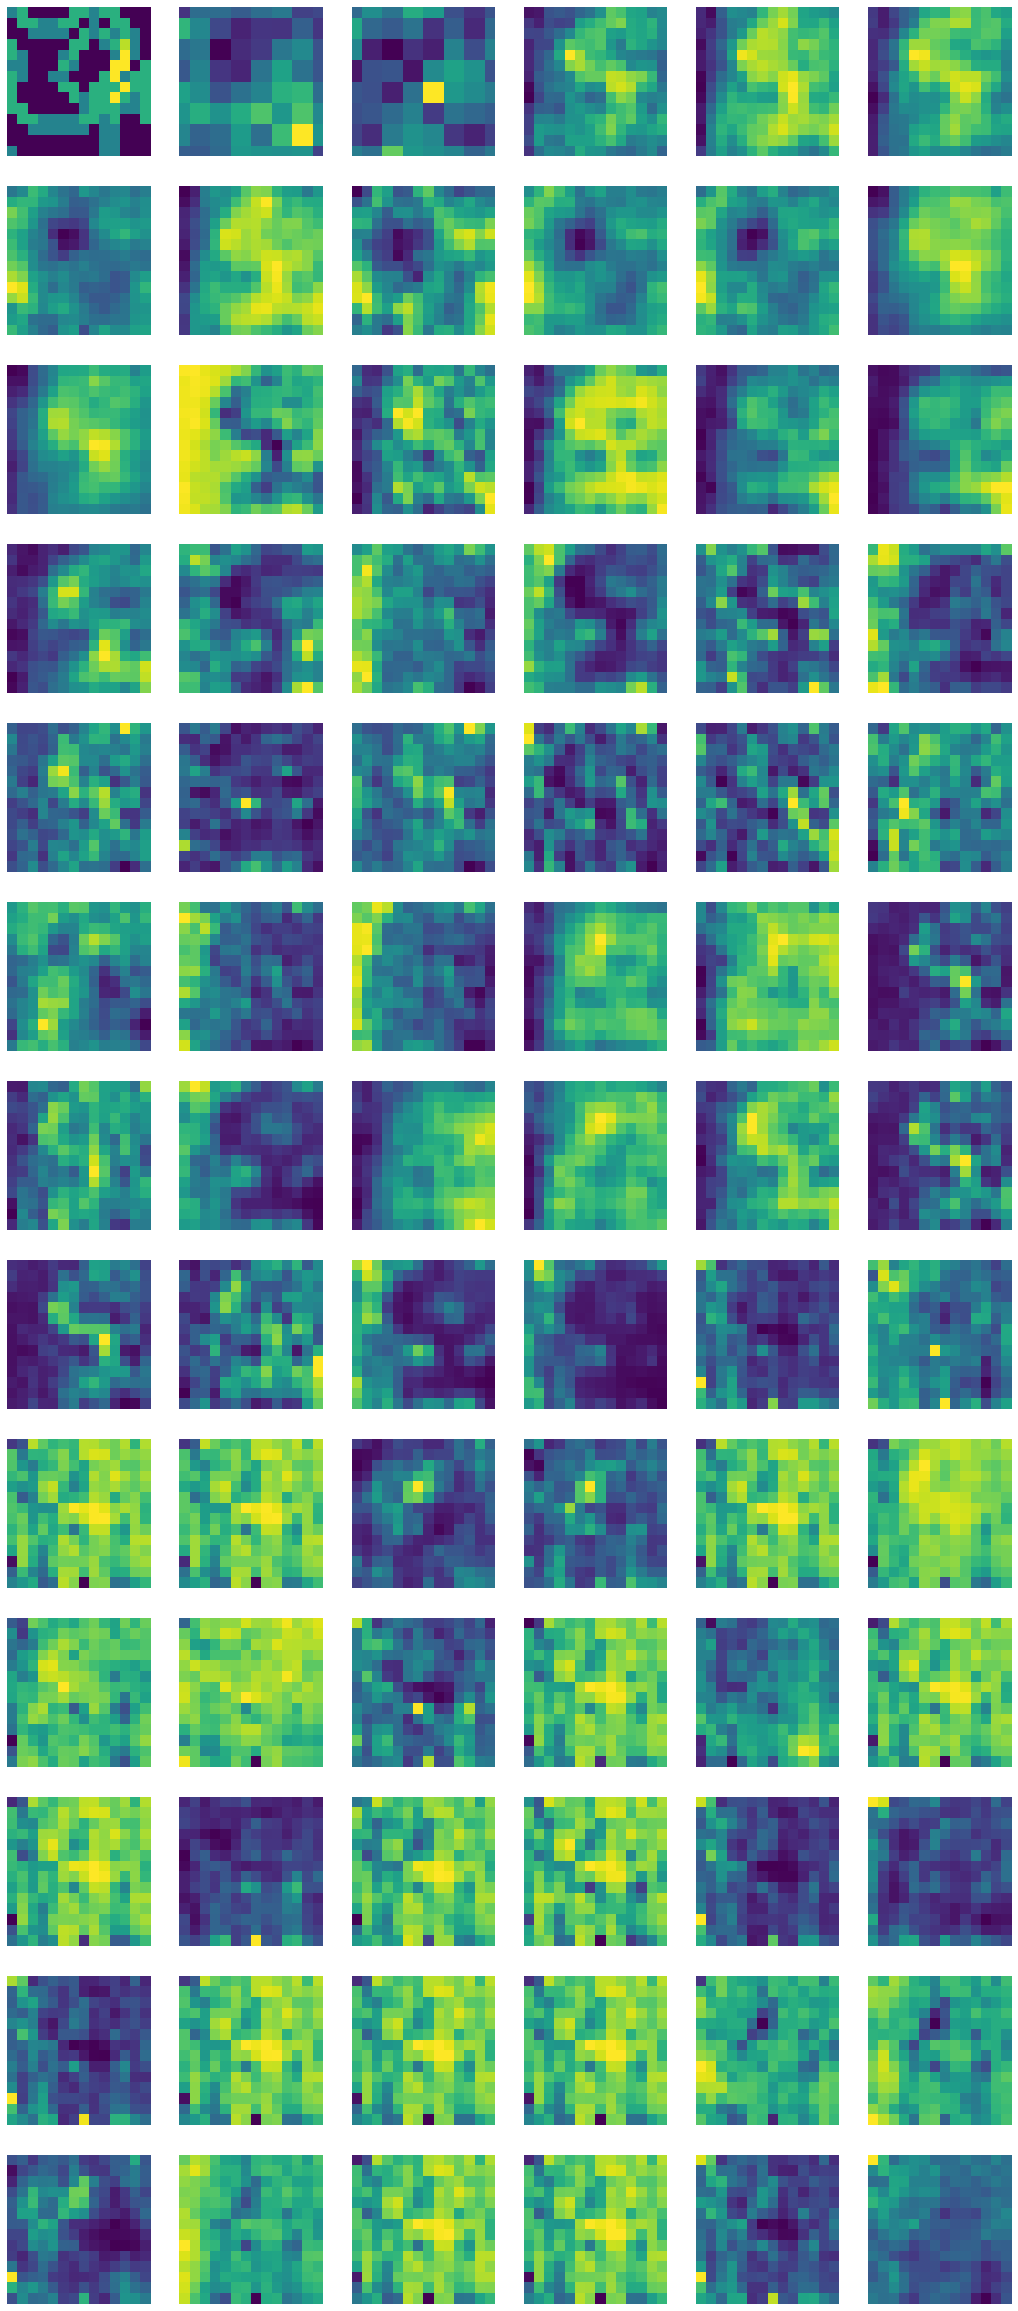

In [92]:
multiplot(f)

In [44]:
v_train_data = ['v3', 'v4', 'v10']

if len(v_train_data) == 1:
    df = pd.read_csv(f'../data/ceo-plantations-train-{v_train_data[0]}.csv')
    plot_ids = df.plotid.drop_duplicates().tolist()

elif len(v_train_data) > 1:
    plot_ids = []
    for i in v_train_data:
        df = pd.read_csv(f'../data/ceo-plantations-train-{i}.csv')
        plot_ids = plot_ids + df.plotid.drop_duplicates().tolist()



In [45]:
# check and remove any plot ids where there are no cloud free images (no feats or s2)
for plot in plot_ids:
    if not os.path.exists(f'../data/train-s2/{plot}.hkl') and not os.path.exists(f'../data/train-features/{plot}.hkl'):
        print(f'Plot id {plot} has no cloud free imagery and will be removed.')
        plot_ids.remove(plot)

In [2]:
# checks for inconsistencies in plot IDs downloaded from s3
s1 = [x[:-4] for x in natsorted(os.listdir("../data/train-s1/")) if ".hkl" in x]
s2 = [x[:-4] for x in natsorted(os.listdir("../data/train-s2/")) if ".hkl" in x]
features = [x[:-4] for x in natsorted(os.listdir("../data/train-features/")) if ".hkl" in x]

labels = [x[:-4] for x in natsorted(os.listdir("../data/train-labels/")) if ".npy" in x]
slope = [x[:-4] for x in natsorted(os.listdir("../data/train-slope/")) if ".npy" in x]

# s2 and features are missing plots 40126 and 40144
print(len(set(s1)))
print(len(set(s2)))
print(len(set(slope)))
print(len(set(features)))
print(len(set(labels)))

li_dif = [i for i in features + s1 + s2 + slope + labels if i not in features or i not in s1 or i not in s2 or i not in slope or i not in labels]
li_dif

In [16]:
def reshape_and_scale(X, y, verbose=False):

    # train test split before reshaping to ensure plot is not mixed samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=22)
    if verbose:
        print(f'X_train: {X_train.shape} X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}')

    # save 14x14 plot for visualization
    X_test_visualize = np.copy(X_test)
    y_test_visualize = np.copy(y_test)

    # reshape arrays with np.prod()
    # apply flattening function, add np.newaxis bc flatten calls arr.shape[-1]
    # manual reshapping - removed np.newaxis because ytrain had shape (1234, 1)
    X_train = np.reshape(X_train, (np.prod(X_train.shape[:-1]), X_train.shape[-1]))
    X_test = np.reshape(X_test, (np.prod(X_test.shape[:-1]), X_test.shape[-1]))
    y_train = np.reshape(y_train, (np.prod(y_train.shape[:])))
    y_test = np.reshape(y_test, (np.prod(y_test.shape[:])))
    if verbose:
        print(f'Flattened X_train: {X_train.shape} X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}')

    # apply standardization on a copy
    X_train_ss = X_train.copy()
    X_test_ss = X_test.copy()

    scaler = StandardScaler()
    X_train_ss = scaler.fit_transform(X_train_ss)
    X_test_ss = scaler.transform(X_test_ss)
    if verbose:
        print(f'Scaled to {np.min(X_train_ss)}, {np.max(X_train_ss)}')
    
    return X_train_ss, X_test_ss, y_train, y_test


In [17]:
# v4 should be a combination of the v3 and v4 CEO surveys
X, y = create_xy((14, 14), ['v3', 'v4'], drop_prob=True, verbose=False)

Baseline: 0.428


In [18]:
X_train_ss, X_test_ss, y_train, y_test = reshape_and_scale(X, y)

## Fit & Evaluate

### Random Forest Classifier

In [32]:
def fit_eval_classifier(X_train, X_test, y_train, y_test, model_name, v_train_data):
    
    '''
    Based on arguments provided, fits and evaluates a classification model
    saving the model to a pkl file and saving scores in a 
    csv. Prints out scores and visualizations for immediate review
    '''
    
    # fit the selected classifier
    if model_name == 'rfc':
        model = RandomForestClassifier(random_state=22)  
        model.fit(X_train, y_train)
    
    elif model_name == 'lgbm':
        model = LGBMClassifier(random_state=22)
        model.fit(X_train, y_train)
        
    elif model_name == 'svm':
        model = SVC(probability=True, random_state=22)
        model.fit(X_train, y_train)
    
    elif model_name == 'xgb':
        model = XGBClassifier(use_label_encoder=False, random_state=22)
        model.fit(X_train, y_train)
    
    elif model_name == 'cat':
        model = CatBoostClassifier(verbose=0, random_state=22)
        model.fit(X_train, y_train)
    
    # save trained model
    filename = f'../models/{model_name}_model_{v_train_data}.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
       
    # get scores and probabilities
    cv = cross_val_score(model, X_train, y_train, cv=3).mean()
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    probs = model.predict_proba(X_test)
    pred = model.predict(X_test)

    # calculate AUC score
    probs_pos = probs[:, 1]
    roc_auc = roc_auc_score(y_test, probs_pos)

    # add new scores
    scores = {'model': f'{model_name}_model_{v_train_data}', 
             'cv': round(cv, 4), 
             'train_score': round(train_score, 4), 
             'test_score': round(test_score, 4), 
             'roc_auc': round(roc_auc, 4)}

    eval_df = pd.DataFrame([scores])
    print(eval_df)
        
    # write scores to new line of csv
    # this is not working
    with open('../models/mvp_scores.csv', 'a') as f:
        eval_df.to_csv('../models/mvp_scores.csv', mode='a', index=False, header=False)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, pred, labels=model.classes_)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot();
 
    # ROC AUC and Precision Recall Curves
    plt.figure(figsize=(17,6)) 
    
    plt.subplot(1,2,1)
    
    # calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, probs_pos)

    # plot roc curve and no skill model
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=model_name, color='green')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right');
    
    plt.subplot(1,2,2)
    
    # calculate precision-recall curve
    fpr, tpr, thresholds = precision_recall_curve(y_test, probs_pos)

    # plot roc curve and no skill model
    no_skill = len(y_test[y_test == 1]) / len(y_test)
    plt.plot([0,1], [no_skill, no_skill], linestyle='--', label='No Skill')

    plt.plot(fpr, tpr, marker='.', label=model_name, color='purple')
    plt.title('Precision Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left');
    
    return None


## Compare Classifier Performance

In [38]:
# Comparison of ROC AUC scores for classifiers

def roc_curve_comp(X_train, X_test, y_train, y_test, model_names, v_train_data):
    
    plt.figure(figsize=(17,6)) 
    
    # ROC curve
    for m in model_names:
        
        with open(f'../models/{m}_model_{v_train_data}.pkl', 'rb') as file:  
             model = pickle.load(file)

        plt.subplot(1,2,1)
        
        # calculate and plot ROC curve
        probs = model.predict_proba(X_test)
        probs_pos = probs[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, probs_pos)
        plt.plot(fpr, tpr, marker=',', label=m)
    
    # plot no skill and custom settings
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right');
    
    # AUC curve
    for m in model_names:
        
        with open(f'../models/{m}_model_{v_train_data}.pkl', 'rb') as file:  
             model = pickle.load(file)

        plt.subplot(1,2,2)

        # calculate and plot precision-recall curve
        probs = model.predict_proba(X_test)
        probs_pos = probs[:, 1]
        fpr, tpr, thresholds = precision_recall_curve(y_test, probs_pos)
        plt.plot(fpr, tpr, marker=',', label=m)
    
    # plot no skill and custom settings
    no_skill = len(y_test[y_test == 1]) / len(y_test)
    plt.plot([0,1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.4, 1.05])
    plt.title('Precision Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left');
    
    return None

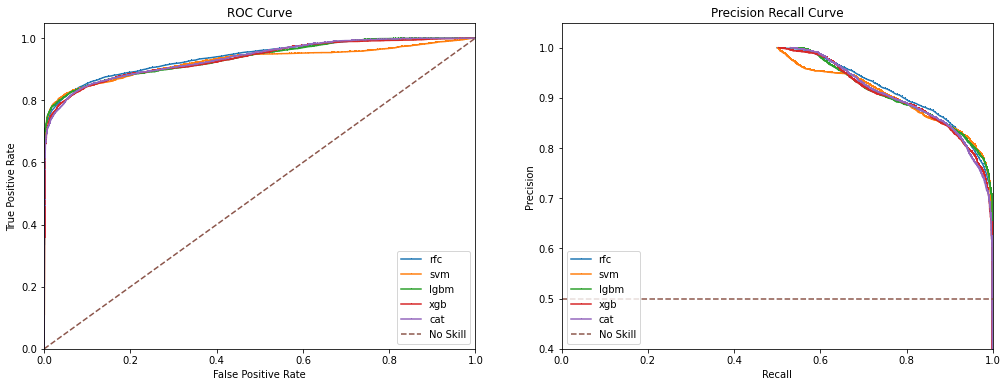

In [11]:
roc_curve_comp(X_train_ss, X_test_ss, y_train, y_test, ['rfc', 'svm', 'lgbm', 'xgb', 'cat'], 'v4')

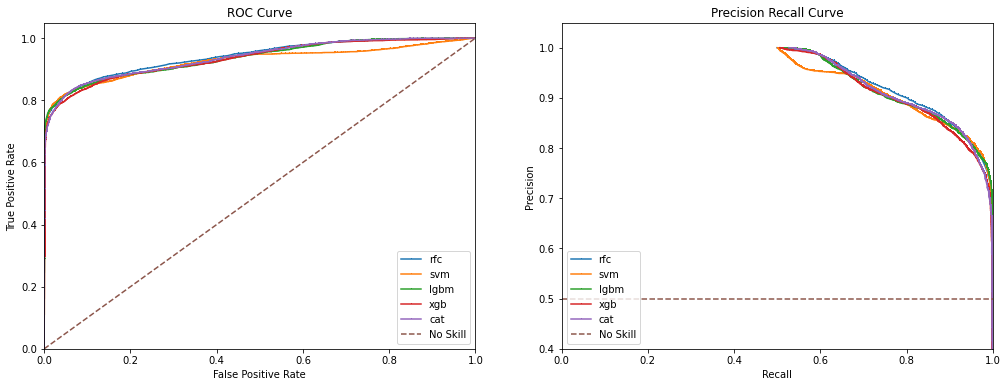

In [39]:
roc_curve_comp(X_train_ss, X_test_ss, y_train, y_test, ['rfc', 'svm', 'lgbm', 'xgb', 'cat'], 'v4_np')

## Other tests to perform
Use tml prediction to subset out the labels so we can differentiate where there is a plantation tree, non-plantation tree, and no tree (Any pixel that is not a TML tree should not be a plantation).

In [ ]:
# threshold the features by .5
labels[features[0] < 0.5] = 0

In [22]:
# these are the CEO plantation labels
labels1 = load_label(1)
labels1

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [81]:
# the TML features - first index of the array is TML probability
feats = load_feats(31)
feats[...,0][feats[...,0] < 0.05] = 0
feats[...,0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0. 

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

## Results

### plantations-train-v4 

- To address the issue of imbalanced classes, additional negative training data was added. 
- The results from the SVM Classifier were positive in that there was less overfitting, almost the same CV score and slightly lower ROC.
- Learning curve: more training samples needed. For the Random Forest Classifier, the training score sits around the maximum and test could be increased. For the SVM Classifier, it seems the curves are approaching.


Next step: determine how to better align the TML model outputs with the rounds of training data to better distinguish performance for different commodities and regions.

distribution
[0. 1.]
[13929 18607]

### plantations-train-v3  

Random Forest
- AUC score indicates there is a 85% chance that the model will be able to distinguish between plantations and non-plantations. 
- According to the confusion matrix, the model is able to predict true positives well. 191 records are wrongly predicted as plantations.
- It is struggling with imbalanced classes, as 93% of the training data is positive for plantations. Need to add more non plantation data.  
- ROC curves should be used when there are roughly equal numbers of observations for each class. Precision-Recall curves should be used when there is a moderate to large class imbalance. For PRs, the goal is to be in the top right corner (1, 1) which means that we classified all positives as positive (Recall=1) and that everything we are classifying as positive is true positive (Precision=1).

distribution:
0:1195 1:18405

## Learning Curve

In [17]:
def learning_curve_comp(model_names, v_train_data, X_train, y_train):

    plt.figure(figsize = (15,8))
    
    colors = ['royalblue',
              'maroon', 
              'magenta', 
              'gold', 
              'limegreen'] 

    for i, x in zip(model_names, colors):

        filename = f'../models/{i}_model_{v_train_data}.pkl'

        with open(filename, 'rb') as file:
            model = pickle.load(file)

        train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(model, 
                                                                              X_train, 
                                                                              y_train, 
                                                                              cv=5, 
                                                                              return_times=True)
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)

        plt.grid()
        plt.plot(train_sizes, train_scores_mean, "x-", color=x, label=f"{i} Training score")
        plt.plot(train_sizes, test_scores_mean, "o-", color=x, label=f"{i} CV score")
    
    plt.xlim([1000, 18000])
    plt.ylim([0.0, 1.2])
    plt.title('Comparison of Learning Curves')
    plt.xlabel('Training Samples')
    plt.ylabel('Score')
    plt.legend(loc='lower right');        
        
    return None

[14:17:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:17:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:18:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:18:07] WARNING: /Users/runner/miniforge3/cond

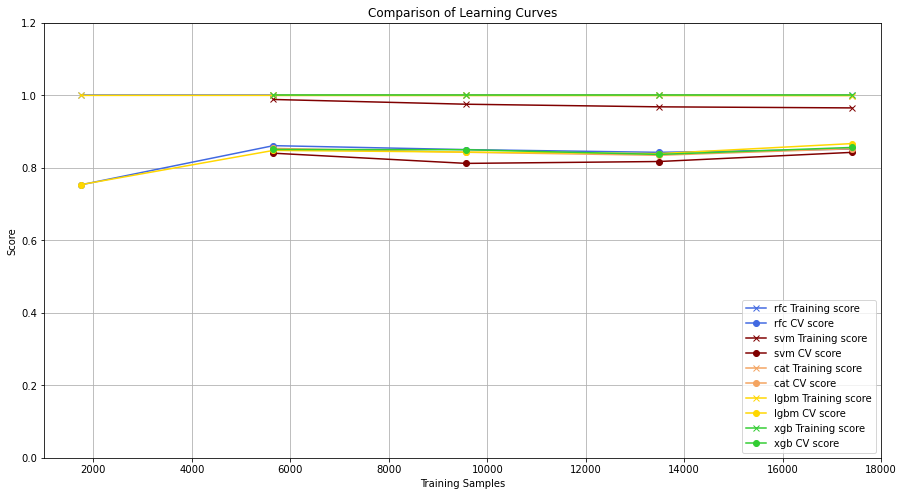

In [18]:
learning_curve_comp(['rfc', 'svm', 'cat', 'lgbm', 'xgb'], 'v4', X_train_ss, y_train)

Learning Curve for TML Feature Comparison

In [ ]:
def learning_curve_comp(model_names, v_train_data, X_train, y_train):
    
    '''
    this visualization plots the learning curves for 3 sets of models,
    one trained with TML features, one trained with TML features no probability,
    and one trained without TML features.
    Each subplot illustrates the learning curves for a single type of classification model
    Goal is to measure impact of transfer learning.
    '''
    subplots = len(model_names)
    
    for i in model_names:
        filename_norm = f'../models/{i}_model_{v_train_data}.pkl'
        filename_np = f'../models/{i}_model_{v_train_data}_np.pkl'
        filename_nf = f'../models/{i}_model_{v_train_data}_nf.pkl'
        
        with open(filename_norm, 'rb') as file:
            norm = pickle.load(filename_norm)

    
    plt.figure(figsize = (15,8))
    
    colors = ['royalblue',
              'maroon', 
              'magenta'] 

    for i, x in zip(model_names, colors):

        filename = f'../models/{i}_model_{v_train_data}.pkl'

        with open(filename, 'rb') as file:
            model = pickle.load(file)

        train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(model, 
                                                                              X_train, 
                                                                              y_train, 
                                                                              cv=5, 
                                                                              return_times=True)
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)

        plt.grid()
        plt.plot(train_sizes, train_scores_mean, "x-", color=x, label=f"{i} Train score")
        plt.plot(train_sizes, test_scores_mean, "o-", color=x, label=f"{i} CV score")
    
    plt.xlim([1000, 32000])
    plt.ylim([0.0, 1.2])
    plt.title('Comparison of Learning Curves')
    plt.xlabel('Training Samples')
    plt.ylabel('Score')
    plt.legend(loc='lower right');        
        
    return None

## Large Features
For the purpose of visual validation of model predictions

In [21]:
def load_large_feats(shape, directory='../data/large-features/'):
    
    # load slope
    slope = hkl.load(directory + 'slope.hkl').squeeze()
    original_shape = slope.shape
    slope = slope[np.newaxis]
    
    # load s1
    s1 = hkl.load(directory + 's1.hkl') 
    if len(s1.shape) == 4:
        s1 = np.median(s1, axis = 0)
    s1 = s1.astype(np.float32)
    
    # load s2
    s2 = hkl.load(directory + 's2.hkl')
    original_shape = s2.shape
    if s2.shape[-1] == 11:
        s2 = np.delete(s2, -1, -1)
    if len(s2.shape) == 4:
        s2 = np.median(s2, axis = 0)
    if not isinstance(s2.flat[0], np.floating):
        assert np.max(s2) > 1
        s2 = s2.astype(np.float32) / 65535
        assert np.max(s2) < 1
        
    # load features
    feats = hkl.load(directory + 'features.hkl').astype(np.float32)
        
    # create the sample and reshape -- input shape should be (500, 500)
    x2 = make_sample(shape, slope, s1, s2, feats)
    x2_reshape = np.reshape(x2, (np.prod(x2.shape[:-1]), x2.shape[-1]))
    
    # return scaled data
    scaler = StandardScaler()
    x2_ss = scaler.fit_transform(x2_reshape)
    
    return x2_ss


def visualize_large_feats(model_name, v_train_data, train_data):

    filename = f'../models/{model_name}_model_{v_train_data}.pkl'
    with open(filename, 'rb') as file:
        model = pickle.load(file)

    preds = model.predict(train_data)
    sns.heatmap(preds.reshape((500, 500)), vmin=0, vmax=.8).set_title(model_name)

    return None

In [ ]:
# we need to be able to see three categories: no tree, tree, plantation tree, on large feats
# will be helpful to see where it's predicting plantations vs non plantation trees
# for pixels where tree probability is >.5 and plantation = 0, make another category

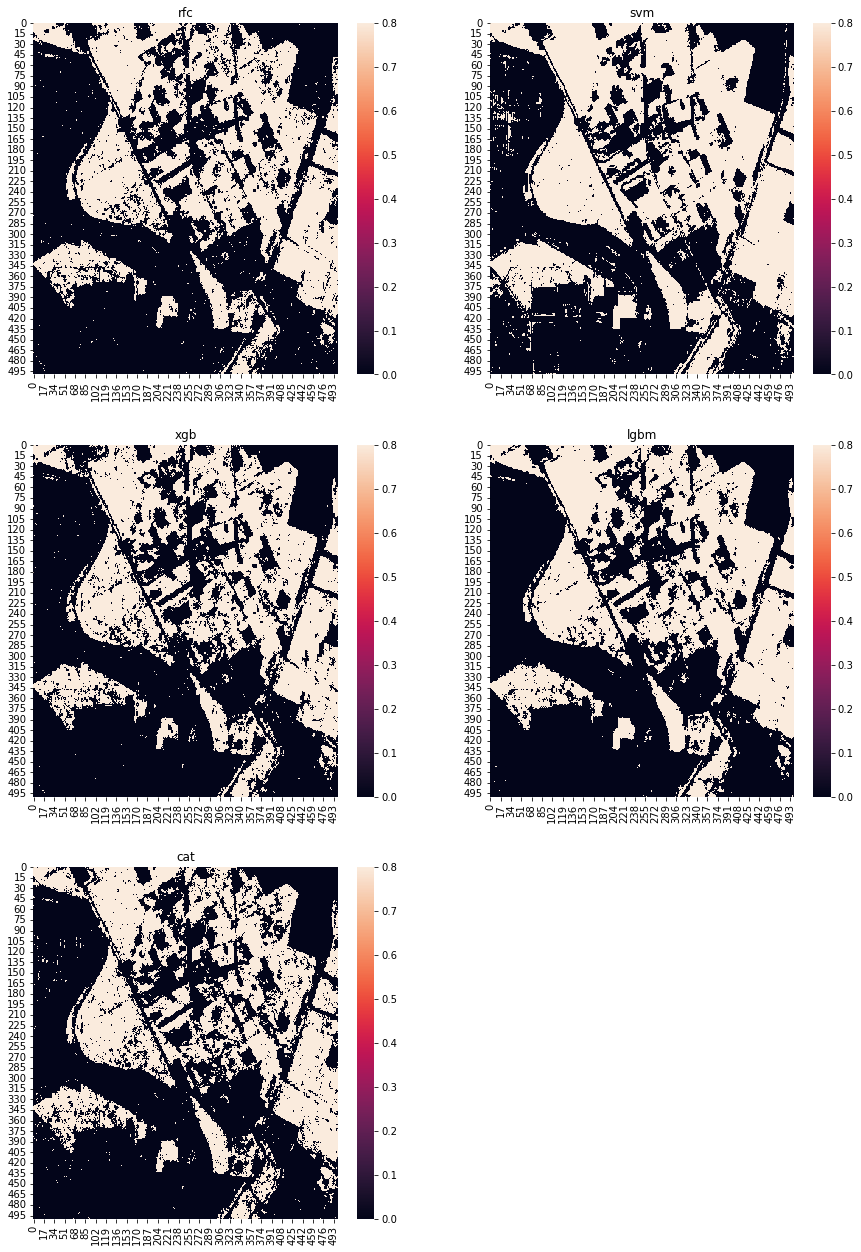

In [22]:
plt.figure(figsize=(15, 22))

x2_ss = load_large_feats((500,500))

# import and visualize each model's predictions on the large feats
plt.subplot(3,2,1)
visualize_large_feats('rfc', 'v4', x2_ss)

plt.subplot(3,2,2)
visualize_large_feats('svm', 'v4', x2_ss)

plt.subplot(3,2,3)
visualize_large_feats('xgb', 'v4', x2_ss)

plt.subplot(3,2,4)
visualize_large_feats('lgbm', 'v4', x2_ss)

plt.subplot(3,2,5)
visualize_large_feats('cat', 'v4', x2_ss)

In [3]:
# OLD 
# load the data for the larger sample
slope, s1, s2, feats = load_large_feats()

# create the sample and reshape
x2 = make_sample((500, 500), slope, s1, s2, feats)
x2_reshape = np.reshape(x2, (np.prod(x2.shape[:-1]), x2.shape[-1]))
x2_reshape.shape

# scale data
scaler = StandardScaler()
x2_ss = scaler.fit_transform(x2_reshape)

(1, 500, 500) (500, 500, 2) (500, 500, 10) (500, 500, 65)


## Old

In [3]:
def rename_files(directory, ext):
    print(f'file count for {directory}: {len(os.listdir(directory))}')
    counter = 0
    
    for file in os.listdir(directory):
        if not file.startswith('.'):
            num = int(file[:-4]) 

            # first condition to address all file names between 100 - 40,000
            if num > 3900 and num < 40000:
                counter + 1
                new_filename = str(num - 3900) + ext
                print(f'original filename: {file} -> new filename: {new_filename}')
                os.rename(os.path.join(directory, file), os.path.join(directory, new_filename))
                
            # second condition to address all file names >40,000
            elif num >= 40000:
                counter + 1
                new_filename = str(num - 39900) + ext
                print(f'original filename: {file} -> new filename: {new_filename}')
                os.rename(os.path.join(directory, file), os.path.join(directory, new_filename))

    return f'{counter} file names updated'

In [3]:
def renumber_files(directory, ext):
    for index, file in enumerate(natsorted(os.listdir(directory))):
        if not file.startswith('.'):
            os.rename(os.path.join(directory, file), directory + str(index) + ext)
    return (f'File count for {directory}: {len(os.listdir(directory))}')

### Random Forest Regressor

In [60]:
## evaluate random forest regressor

# import the saved model
rfr_filename = 'models/rfr_model_v4.pkl'
with open(rfr_filename, 'rb') as file:  
    rfr = pickle.load(file)

# get scores
cv_rfr = cross_val_score(rfr, X_train_ss, y_train, cv=3).mean()
train_rfr = rfr.score(X_train_ss, y_train)
test_rfr = rfr.score(X_test_ss, y_test)

print('Random Forest Regressor')
print(f'Cross val: {round(cv_rfr,3)} Train Score: {round(train_rfr,3)}, Test Score: {round(test_rfr,3)}') 

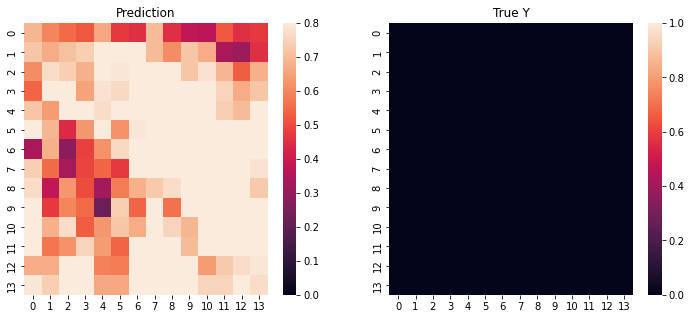

<Figure size 1080x1440 with 0 Axes>

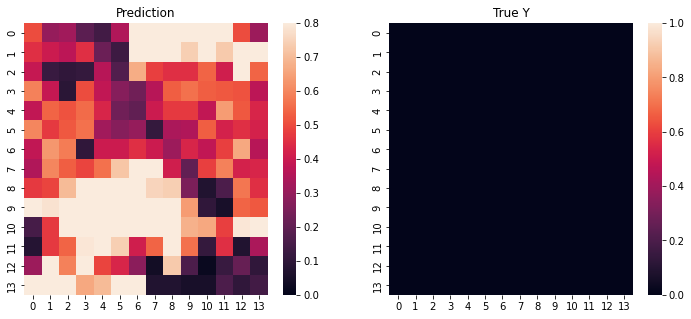

<Figure size 1080x1440 with 0 Axes>

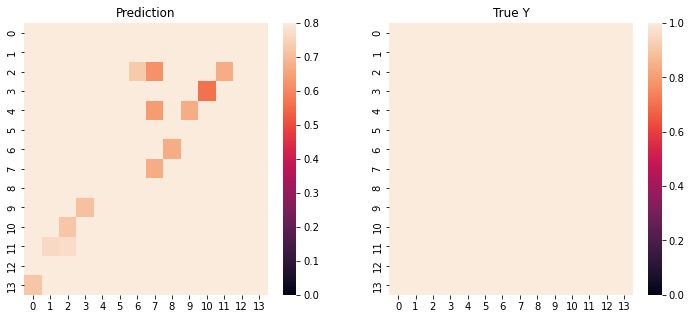

<Figure size 1080x1440 with 0 Axes>

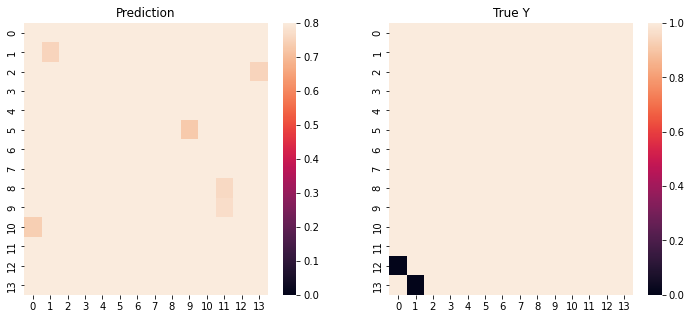

<Figure size 1080x1440 with 0 Axes>

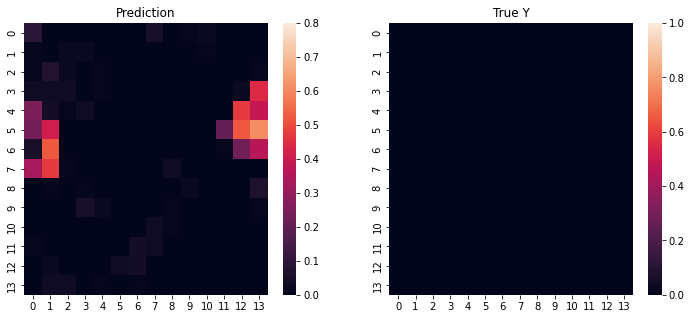

<Figure size 1080x1440 with 0 Axes>

In [20]:
## apply the model to a single training sample, visualize as heatmap


# get a 14x14 grid for a single plot
# reshape and scale (14, 14, 78) -> (196, 78)
for num in range(0, 5):
    plot = num
    X = X_test_visualize[plot]
    X = X.reshape((X.shape[0] * X.shape[1], X.shape[2]))
    X = scaler.transform(X)
    Y = y_test_visualize[plot]
    
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    plt.figure(figsize=(15,20))

    sns.heatmap(rfr.predict(X).reshape((14, 14)), ax=axes[0], vmin=0, vmax=.8)
    axes[0].set_title("Prediction")
    sns.heatmap(Y, ax=axes[1], vmin=0, vmax=1.0)
    axes[1].set_title("True Y");

In [ ]:
## Plot learning curve for svm and rfc
## this is the more manual option for each model

fig, axes = plt.subplots(1,2, figsize=(17,6))

with open('../models/rfc_model_v4.pkl', 'rb') as file:  
    rfc = pickle.load(file)

train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(rfc, 
                                                                      X_train_ss, 
                                                                      y_train, 
                                                                      cv=5, 
                                                                      return_times=True)
axes[0].set_title('Learning Curves (Random Forest Classifier)')
axes[0].set_xlabel("Training Samples")
axes[0].set_ylabel("Score")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot rfc learning curve
axes[0].grid()
axes[0].fill_between(train_sizes,
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std,
                    alpha=0.1,
                    color="r")

axes[0].fill_between(train_sizes,
                    test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std,
                    alpha=0.1,
                    color="b")

axes[0].plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
axes[0].plot(train_sizes, test_scores_mean, "o-", color="b", label="Cross-validation score")
axes[0].legend(loc="best")

# Plot svm learning curve
with open('../models/svm_model_v4.pkl', 'rb') as file:  
    svm = pickle.load(file)

train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(svm, 
                                                                      X_train_ss, 
                                                                      y_train, 
                                                                      cv=5, 
                                                                      return_times=True)

axes[1].set_title('Learning Curves (Support Vector Machine)')
axes[1].set_xlabel("Training Samples")
axes[1].set_ylabel("Score")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


axes[1].grid()
axes[1].fill_between(train_sizes,
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std,
                    alpha=0.1,
                    color="r")

axes[1].fill_between(train_sizes,
                    test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std,
                    alpha=0.1,
                    color="b")

axes[1].plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
axes[1].plot(train_sizes, test_scores_mean, "o-", color="b", label="Cross-validation score")
axes[1].legend(loc="best");